This notebook is mainly used to generate relevant plots of the simulation

# Plotting the resulting signals

In [1]:
using CSV, DataFrames, JSON, JLD, OrderedCollections, NPZ
using FFTW
using Roots
using Plots
using LinearAlgebra

In [572]:
push!(LOAD_PATH, "/home/elaksono/eo-comb/SplitStep/src/");
using Revise
using Constant
using PlotPulse
using ECPO
using Materials
using Analytics

[ Info: Precompiling Analytics [top-level]


## OPO CW

In [305]:
Pp_edwin = load("./data/full-cw-opo_output-powers.jld")["Pp_out"];
Ps_edwin = load("./data/full-cw-opo_output-powers.jld")["Ps_out"];
Pi_edwin = load("./data/full-cw-opo_output-powers.jld")["Pi_out"];
Ptot_edwin = Pp_edwin .+ Ps_edwin .+ Pi_edwin;

In [287]:
opo_folder = "./output/test_opo_cw_10-04-24/"

opo_pars = JSON.parse(open(opo_folder * "parameters.json"))
opo_time = load(opo_folder * "opo_time.jld")["time"]
sorted_id = sortperm(opo_time)
opo_time = opo_time[sorted_id]

opo_omega = sort(load(opo_folder * "opo_omega_s.jld")["omega"])

T_points = collect(1:1:opo_pars["n_round"])
opo_amp = zeros(ComplexF64, length(pulse_time), 3, length(T_points))
# opo_dN = zeros(length(pulse_time), 3, length(T_points))

for (i,Ts) in enumerate(T_points)
    opo_amp[:,:,i] = load(opo_folder * "opo_T" * string(Ts) * "_out.jld")["amp"][sorted_id,:];
end

In [288]:
(λp, λs) = (opo_pars["lambda_p"], opo_pars["lambda_s"])
λi = λp * λs / (λs - λp)
(ωp, ωs, ωi) = (2*pi*c0*1e6) ./ [λp; λs; λi]
(Ep, Es, Ei) = hbar .* [ωp; ωs; ωi]

# Power in mW
opo_s_pow = abs2.(opo_amp[1,1,:]) .* Es * 1e12 * 1e3;
opo_i_pow = abs2.(opo_amp[1,2,:]) .* Ei * 1e12 * 1e3; 
opo_p_pow = abs2.(opo_amp[1,3,:]) .* Ep * 1e12 * 1e3;
opo_tot_pow = opo_s_pow + opo_i_pow + opo_p_pow;

In [291]:
if opo_pars["kappa_unit"] == "intensity"
    kappa = opo_pars["wg_kappa"] * sqrt(hbar * ωs * ωi / ωp * 1e12)
else
    kappa = opo_pars["wg_kappa"]
end

aSS = sqrt(opo_pars["out_signal"]) * inv_sinc(1/opo_pars["p_th"])/(kappa * opo_pars["L_wg"])
aSS_pow = abs2(aSS) .* ones(size(opo_s_pow)) * Es * 1e12 * 1e3;

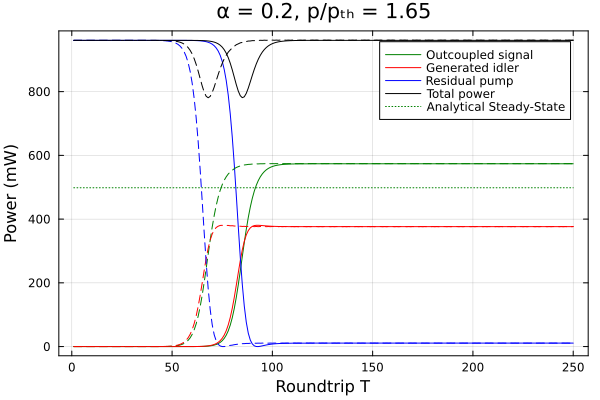

In [314]:
pow_plot = plot(frame=:box, xlabel = "Roundtrip T", ylabel = "Power (mW)", legend=:topright, 
    title="α = $(opo_pars["loss_signal"]), p/pₜₕ = $(opo_pars["p_th"])")

plot!(T_points, opo_s_pow, label = "Outcoupled signal", color=:green)
plot!(T_points, opo_i_pow, label = "Generated idler", color=:red)
plot!(T_points, opo_p_pow, label = "Residual pump", color=:blue)
plot!(T_points, opo_tot_pow, label = "Total power", color=:black)
plot!(T_points, aSS_pow, label = "Analytical Steady-State", color=:green, linestyle=:dot)

plot!(T_points, Ps_edwin[1:T_points[end]] * 1e3, linestyle=:dash, color=:green, label=nothing)
plot!(T_points, Pi_edwin[1:T_points[end]] * 1e3, linestyle=:dash, color=:red, label=nothing)
plot!(T_points, Pp_edwin[1:T_points[end]] * 1e3, linestyle=:dash, color=:blue, label=nothing)
plot!(T_points, Ptot_edwin[1:T_points[end]] * 1e3, color=:black, linestyle=:dash, label=nothing)

savefig("./figures/opo_cw_dynamics.png")
pow_plot

## OPO - dispersive only

In [103]:
disp_folder = "./output/test_disp_opo_10-08-24/"
disp_fig_folder = replace(dirname(disp_folder), "output/" => "figures/")
if !isdir(disp_fig_folder) mkdir(disp_fig_folder) end

disp_pars = JSON.parse(open(disp_folder * "parameters.json"))
disp_time = load(disp_folder * "disp_time.jld")["time"]
sorted_id = sortperm(disp_time)
disp_time = disp_time[sorted_id]

disp_omega = sort(load(disp_folder * "disp_omega_s.jld")["omega"])
arr_omega = sort(load(disp_folder * "disp_omega.jld")["omega"])

T_points = collect(1:1:disp_pars["n_round"])
disp_amp = zeros(ComplexF64, length(disp_time), 3, length(T_points))
disp_amp_ft = zeros(ComplexF64, length(disp_time), 3, length(T_points))
disp_amp_anl = zeros(ComplexF64, length(disp_time), 3, length(T_points))
disp_amp_ft_anl = zeros(ComplexF64, length(disp_time), 3, length(T_points))

for (i,Ts) in enumerate(T_points)
    output = load(disp_folder * "disp_T" * string(Ts) * "_out.jld")["amp"]
    disp_amp[:,:,i] = output[sorted_id,:]
    disp_amp_ft[:,:,i] = fft(output,1)[sorted_id,:]
    
    output2 = load(disp_folder * "disp_ft_T" * string(Ts) * ".jld")["amp_ft"]
    disp_amp_ft_anl[:,:,i] = output2[sorted_id,:]
    disp_amp_anl[:,:,i] = ifft(output2,1)[sorted_id,:]
end

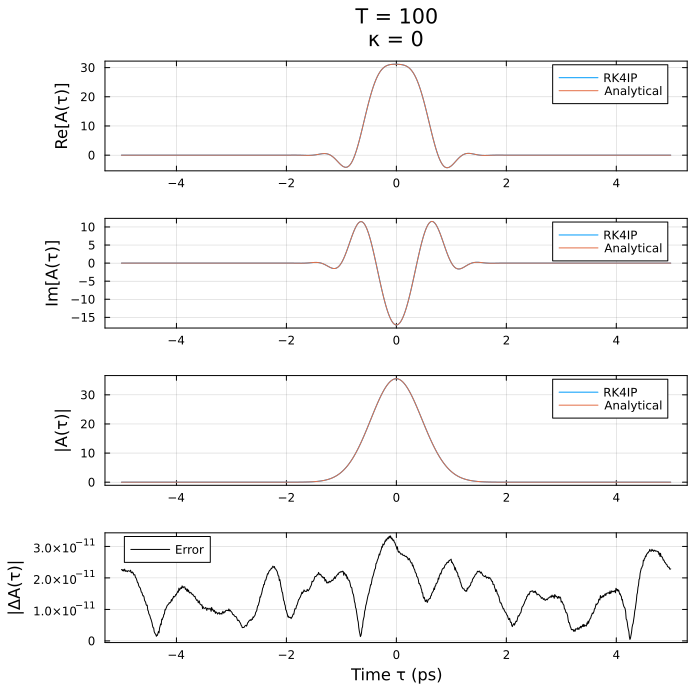

In [104]:
# Dispersive part - time domain
pulse_id = 1
T_id = 100

plot_real = plot(frame=:box, xlabel="", ylabel = "Re[A(τ)]", title = "T = $(T_id)\nκ = 0")
plot!(disp_time, real.(disp_amp[:,pulse_id,T_id]), label = "RK4IP")
plot!(disp_time, real.(disp_amp_anl[:,pulse_id,T_id]), label = "Analytical")

plot_imag = plot(frame=:box, xlabel = "", ylabel = "Im[A(τ)]")
plot!(disp_time, imag.(disp_amp[:,pulse_id,T_id]), label = "RK4IP")
plot!(disp_time, imag.(disp_amp_anl[:,pulse_id,T_id]), label = "Analytical")

plot_abs = plot(frame=:box, xlabel = "", ylabel = "|A(τ)|")
plot!(disp_time, abs.(disp_amp[:,pulse_id,T_id]), label = "RK4IP")
plot!(disp_time, abs.(disp_amp_anl[:,pulse_id,T_id]), label = "Analytical")

plot_error = plot(frame=:box, xlabel = "Time τ (ps)", ylabel = "|ΔA(τ)|")
plot!(disp_time, abs.(disp_amp[:,pulse_id,T_id] .- disp_amp_anl[:,pulse_id,T_id]), label = "Error", color=:black)

disp_plot_full = plot(plot_real, plot_imag, plot_abs, plot_error, layout = (4,1), size = (700,700), link=:x)
savefig(disp_plot_full, disp_fig_folder * "disp_pulse_$(pulse_id)_T$(T_id).png");

disp_plot_full

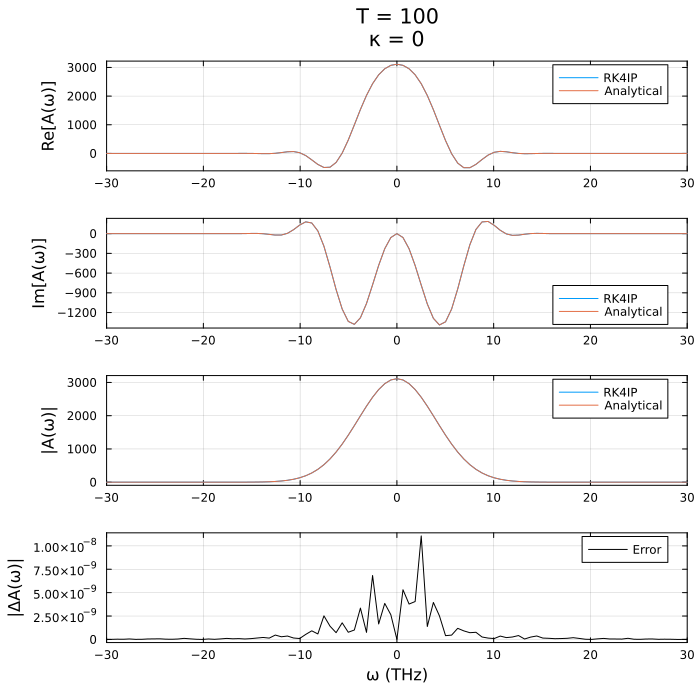

In [105]:
# Dispersive part - freq domain
pulse_id = 1
T_id = 100
xmax = 30.0

plot_real = plot(frame=:box, xlabel="", ylabel = "Re[A(ω)]", title = "T = $(T_id)\nκ = 0")
plot!(arr_omega, real.(disp_amp_ft[:,pulse_id,T_id]), label = "RK4IP")
plot!(arr_omega, real.(disp_amp_ft_anl[:,pulse_id,T_id]), label = "Analytical")

plot_imag = plot(frame=:box, xlabel = "", ylabel = "Im[A(ω)]")
plot!(arr_omega, imag.(disp_amp_ft[:,pulse_id,T_id]), label = "RK4IP")
plot!(arr_omega, imag.(disp_amp_ft_anl[:,pulse_id,T_id]), label = "Analytical")

plot_abs = plot(frame=:box, xlabel = "", ylabel = "|A(ω)|")
plot!(arr_omega, abs.(disp_amp_ft[:,pulse_id,T_id]), label = "RK4IP")
plot!(arr_omega, abs.(disp_amp_ft_anl[:,pulse_id,T_id]), label = "Analytical")

plot_error = plot(frame=:box, xlabel = "ω (THz)", ylabel = "|ΔA(ω)|")
plot!(arr_omega, abs.(disp_amp_ft[:,pulse_id,T_id] .- disp_amp_ft_anl[:,pulse_id,T_id]), label = "Error", color=:black)

disp_plot_ft_full = plot(plot_real, plot_imag, plot_abs, plot_error, layout = (4,1), size = (700,700), link=:x, xlim = (-xmax, xmax))

savefig(disp_plot_ft_full, disp_fig_folder * "disp_pulse_ft_$(pulse_id)_T$(T_id).png");
disp_plot_ft_full

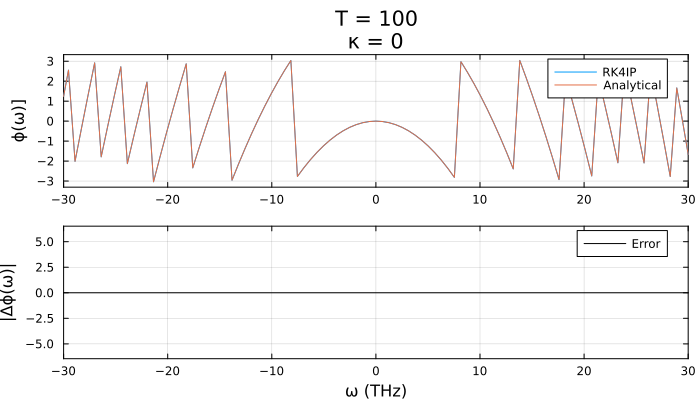

In [107]:
# Dispersive part - freq domain
pulse_id = 1
T_id = 100
xmax = 30.0

plot_arg = plot(frame=:box, xlabel="", ylabel = "ϕ(ω)]", title = "T = $(T_id)\nκ = 0\n")
plot!(arr_omega, angle.(disp_amp_ft[:,pulse_id,T_id]), label = "RK4IP")
plot!(arr_omega, angle.(disp_amp_ft_anl[:,pulse_id,T_id]), label = "Analytical")

plot_error = plot(frame=:box, xlabel = "ω (THz)", ylabel = "|Δϕ(ω)|")
plot!(arr_omega, angle.(disp_amp_ft[:,pulse_id,T_id]) .- angle.(disp_amp_ft_anl[:,pulse_id,T_id]), 
    label = "Error", color=:black)

disp_phase_plot = plot(plot_arg, plot_error, layout = (2,1), size = (700,400), link=:x, xlim = (-xmax, xmax))

savefig(disp_phase_plot, disp_fig_folder * "disp_phase_$(pulse_id)_T$(T_id).png");
disp_phase_plot

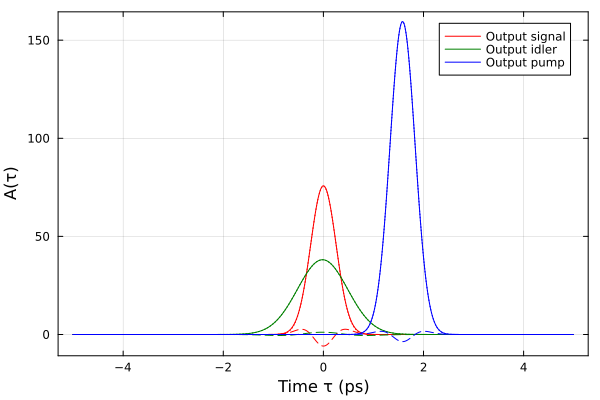

In [108]:
n_trip = T_points[10]
disp_amp_plot = plot(frame=:box, xlabel = "Time τ (ps)", ylabel = "A(τ)", legend=:topright)

plot!(disp_time, real.(disp_amp[:,1,n_trip]), label = nothing, color=:red, linestyle=:dot)
plot!(disp_time, imag.(disp_amp[:,1,n_trip]), label = nothing, color=:red, linestyle=:dash)
plot!(disp_time, abs.(disp_amp[:,1,n_trip]), label = "Output signal", color=:red)

plot!(disp_time, real.(disp_amp[:,2,n_trip]), label = nothing, color=:green, linestyle=:dot)
plot!(disp_time, imag.(disp_amp[:,2,n_trip]), label = nothing, color=:green, linestyle=:dash)
plot!(disp_time, abs.(disp_amp[:,2,n_trip]), label = "Output idler", color=:green)

plot!(disp_time, real.(disp_amp[:,3,n_trip]), label = nothing, color=:blue, linestyle=:dot)
plot!(disp_time, imag.(disp_amp[:,3,n_trip]), label = nothing, color=:blue, linestyle=:dash)
plot!(disp_time, abs.(disp_amp[:,3,n_trip]), label = "Output pump", color=:blue)

## Plotting QAM-OPO pulse vs time

In [627]:
ecpo_folder = "./output/adb_ecpo_3cm_highP_3_10-22-24/"
(Tmin, dT, Tmax) = (1,1,500)

T_points = collect(Tmin:dT:Tmax)
fig_folder = replace(dirname(ecpo_folder), "output/" => "figures/")
if !isdir(fig_folder) mkdir(fig_folder) end

ecpo_pars = JSON.parse(open(ecpo_folder * "parameters.json"))
(λp, λs) = (ecpo_pars["lambda_p"], ecpo_pars["lambda_s"])
λi = λp * λs / (λs - λp)
(ωp, ωs, ωi) = (2*pi*c0*1e6) ./ [λp; λs; λi]
(Ep, Es, Ei) = hbar .* [ωp; ωs; ωi]

pulse_time = load(ecpo_folder * "pulse_time.jld")["time"]
sorted_id = sortperm(pulse_time)
pulse_time = pulse_time[sorted_id]

pulse_omega = sort(load(ecpo_folder * "pulse_omega_s.jld")["omega"])
pulse_lambda = (2*pi*c0) ./ (pulse_omega) * 1e-6

pulse_amp = zeros(ComplexF64, length(pulse_time), 3, length(T_points))
pulse_amp_ft = zeros(ComplexF64, length(pulse_time), 3, length(T_points))

pulse_dN = zeros(length(pulse_time), 3, length(T_points))

for (i,Ts) in enumerate(T_points)
    temp = load(ecpo_folder * "pulse_T" * string(Ts) * "_out.jld")["amp"]
    pulse_amp[:,:,i] = temp[sorted_id,:]
    pulse_amp_ft[:,:,i] = fft(temp, 1)[sorted_id,:]
end

In [628]:
wg_mat_test = eval(Meta.parse(ecpo_pars["wg_mat"]))

omg_ctr_test = [ωs; ωi; ωp] .* 1e-12
delta_beta_test = (beta_func(wg_mat_test, ωp * 1e-12) - beta_func(wg_mat_test, ωs * 1e-12) - 
    beta_func(wg_mat_test, ωi * 1e-12))
qpm_lambda_test = 1e3 * 2*pi/ delta_beta_test
zc_t = ecpo_pars["L_wg"] / 2
dk_1 = ecpo_pars["phi_z_pars"][end]

bw_info = solve_bw_lbd_linear(omg_ctr_test, qpm_lambda_test, lnlt_z, (zc_t, dk_1));

In [629]:
abs2(9426.45482168484) .* (Ep * 1e12)

16.58944580328414

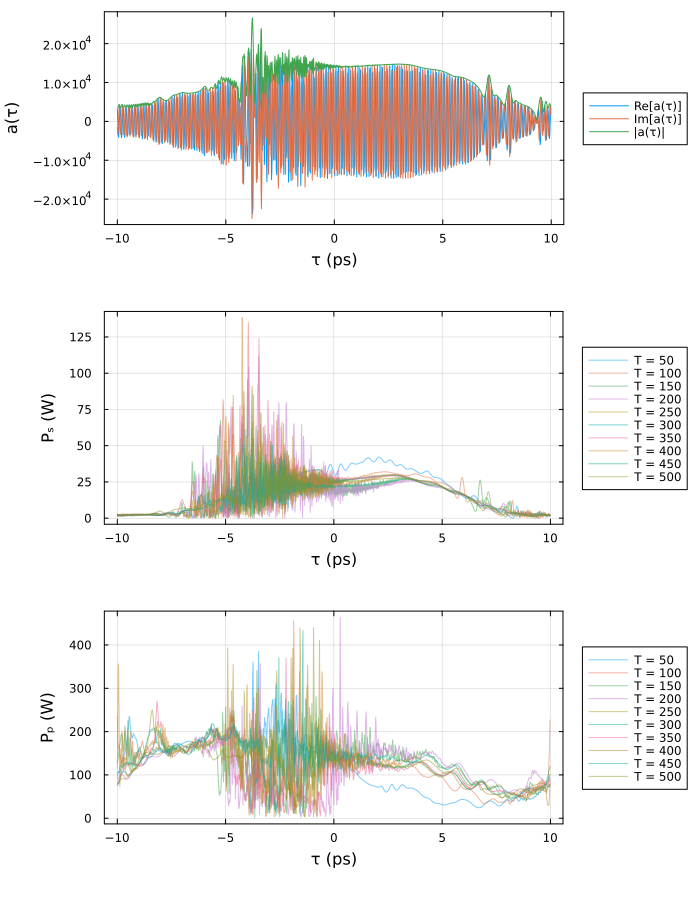

In [630]:
test_ecpo_signal_amp = plot(frame=:box, xlabel = "τ (ps)", ylabel = "a(τ)", legend=:outerright, size = (700,280), 
    left_margin=5Plots.mm, bottom_margin=5Plots.mm)
test_ecpo_signal = plot(frame=:box, xlabel = "τ (ps)", ylabel = "Pₛ (W)", legend=:outerright, size = (700,280), 
    left_margin=5Plots.mm, bottom_margin=5Plots.mm)
test_ecpo_pump = plot(frame=:box, xlabel = "τ (ps)", ylabel = "Pₚ (W)", legend=:outerright, size = (700,280), 
    left_margin=5Plots.mm, bottom_margin=5Plots.mm)

ecpo_signal_final = pulse_amp[:,1,end]

plot!(test_ecpo_signal_amp, pulse_time, real.(ecpo_signal_final), label = "Re[a(τ)]")
plot!(test_ecpo_signal_amp, pulse_time, imag.(ecpo_signal_final), label = "Im[a(τ)]")
plot!(test_ecpo_signal_amp, pulse_time, abs.(ecpo_signal_final), label = "|a(τ)|")

ecpo_signal_pow = abs2.(pulse_amp[:,1,:]) .* (Es * 1e12);
ecpo_pump_pow = abs2.(pulse_amp[:,3,:]) .* (Ep * 1e12);

for (i,Ts) in enumerate(T_points[50:50:500])
    plot!(test_ecpo_signal, pulse_time, ecpo_signal_pow[:,Ts], opacity = 0.5, label = "T = " * string(Ts))
    plot!(test_ecpo_pump, pulse_time, ecpo_pump_pow[:,Ts], opacity = 0.5, label = "T = " * string(Ts))
end

savefig(test_ecpo_signal_amp, fig_folder * "/ecpo_signal_amp_evolve.png");
savefig(test_ecpo_signal, fig_folder * "/ecpo_signal_evolve.png");
savefig(test_ecpo_pump, fig_folder * "/ecpo_pump_evolve.png");

test_ecpo = plot(test_ecpo_signal_amp, test_ecpo_signal, test_ecpo_pump, layout=(3,1), size = (700,900))

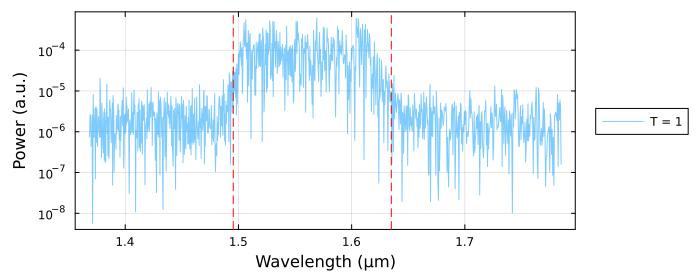

In [637]:
ft_ecpo_signal = plot(frame=:box, xlabel = "Wavelength (μm)", ylabel = "Power (a.u.)", 
    legend=:outerright, size = (700,280), left_margin=5Plots.mm, bottom_margin=5Plots.mm, yscale=:log)

ecpo_signal_ft = abs2.(pulse_amp_ft[:,1,:]);

for (i,Ts) in enumerate(T_points[1:1:1])
    plot!(ft_ecpo_signal, pulse_lambda, ecpo_signal_ft[:,Ts], opacity = 0.5, label = "T = " * string(Ts))
end

vline!([bw_info["lbd_1"]], label=nothing, linewidth=1, color=:red, linestyle=:dash)
vline!([bw_info["lbd_2"]], label=nothing, linewidth=1, color=:red, linestyle=:dash)

# savefig(ft_ecpo_signal, fig_folder * "/ecpo_signal_ft_evolve.png");

ft_ecpo_signal

In [632]:
T_new = collect(1:500)
pulse_signal_full = zeros(ComplexF64, length(pulse_time), length(T_new))

for (i,Ts) in enumerate(T_new)
    pulse_signal_full[:,i] = load(ecpo_folder * "pulse_T" * string(Ts) * "_out.jld")["amp"][sorted_id,1,:]
end

signal_full_pow = abs2.(pulse_signal_full) .* (Es * 1e12);

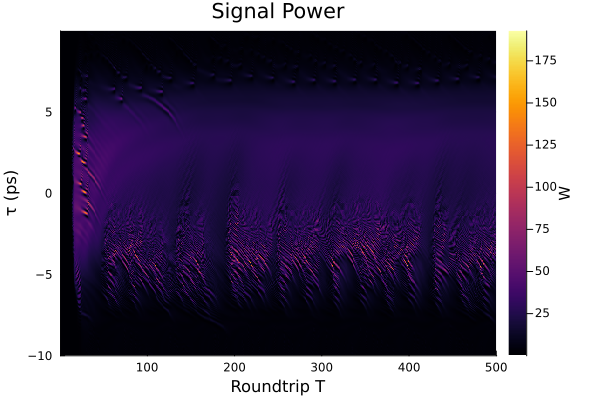

In [633]:
test_ecpo_xy = heatmap(T_new, pulse_time, signal_full_pow, ylabel = "τ (ps)", xlabel = "Roundtrip T", 
    title = "Signal Power", rightmargin = 5Plots.mm, colorbar_title = "W", colorbar=:left)
savefig(test_ecpo_xy, fig_folder * "/ecpo_evolve_xy.png")
test_ecpo_xy

In [634]:
T_new = collect(1:500)
pulse_signal_ft_full = zeros(ComplexF64, length(pulse_time), length(T_new))

for (i,Ts) in enumerate(T_new)
    temp = load(ecpo_folder * "pulse_T" * string(Ts) * "_out.jld")["amp"][:,1,:]
    pulse_signal_ft_full[:,i] = fft(temp, 1)[sorted_id,:]
end

signal_ft_full_pow = abs2.(pulse_signal_ft_full);
signal_ft_full_pow = signal_ft_full_pow ./ maximum(signal_ft_full_pow);

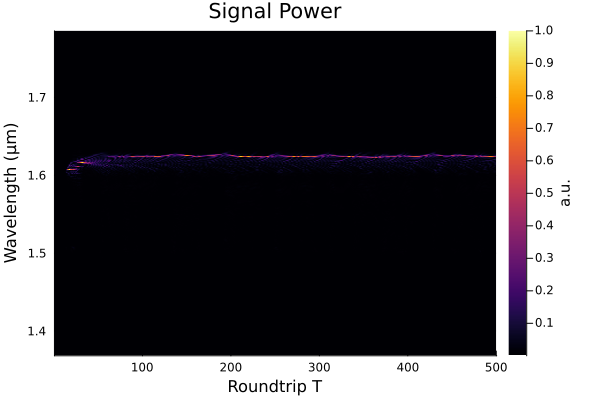

In [635]:
test_ecpo_xy_ft = heatmap(T_new, pulse_lambda[end:-1:1], signal_ft_full_pow[end:-1:1,:], ylabel = "Wavelength (μm)", 
    xlabel = "Roundtrip T", title = "Signal Power", rightmargin = 5Plots.mm, colorbar_title = "a.u.", colorbar=:left)
savefig(test_ecpo_xy_ft, fig_folder * "/ecpo_evolve_xy_ft.png")
test_ecpo_xy_ft

## Spectrogram

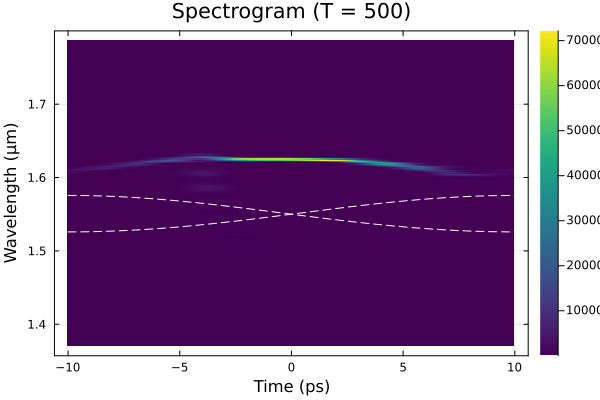

In [636]:
M = 256
ii = 500
test_spx = load(ecpo_folder * "ecpo_spx.jld")
test_spec = calculate_spectrogram(pulse_signal_full[:,ii], M, window_type=:gaussian, 
    arr_time = pulse_time, arr_omega = pulse_omega, hop_size = 1, cyclical = true)

plot_spec = plot()
plot_spectrogram(test_spec, x_unit = "(ps)", y_unit = "(μm)", y_axis = "lbd", 
    title = "Spectrogram (T = $(T_new[ii]))", plot_holder = plot_spec)
plot!(plot_spec, test_spx["time"], test_spx["branch_1"], color=:white, linestyle=:dash, label=nothing, frame=:box)
plot!(plot_spec, test_spx["time"], test_spx["branch_2"], color=:white, linestyle=:dash, label=nothing)

savefig(fig_folder * "/spectrogram.png")

plot_spec

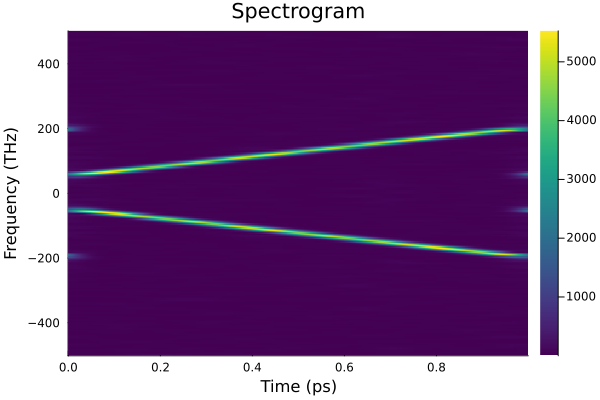

In [94]:
# Testing the spectrogram: A chirped signal
fs = 1000  # Sampling frequency in Hz
T = 1  # Duration in seconds
N = fs * T  # Total number of samples

t = (0:N-1) / fs
f1 = 50  # Start frequency of chirp
f2 = 200  # End frequency of chirp

# Create a chirp signal that increases and decreases cyclically
signal = sin.(2π .* (f1 .+ 0.5 * (f2 - f1) .* t) .* t) + 0.2 .* randn(N)  # Adding some noise

M = 256  # Window size

# Plot the spectrogram with a Gaussian window including negative frequencies
out_spec = calculate_spectrogram(signal, M, window_type=:gaussian, fs=fs, hop_size = 1)
plot_spectrogram(out_spec)

In [5]:
# Sample data (2D array)
rows, cols = 512, 10
data = rand(rows, cols)  # Replace with your 2D array data

# Calculate the spectrogram using a Gaussian window
spec = calculate_spectrogram(data, window_size=128, overlap=64, stddev=0.4)

# Plot the spectrogram for the first column (or any column of your choice)
# heatmap(spec, xlabel="Time", ylabel="Frequency", title="Spectrogram with Gaussian Window")

7×10 Matrix{Vector{Float64}}:
 [5.53937, 0.958247, 0.426566, 0.255302, 0.0821063, 0.0850487, 0.397319, 0.341546, 0.227456, 0.299452  …  0.281795, 0.299452, 0.227456, 0.341546, 0.397319, 0.0850487, 0.0821063, 0.255302, 0.426566, 0.958247]  …  [5.59051, 0.859536, 0.146089, 0.159338, 0.376149, 0.239136, 0.497529, 0.411672, 0.248412, 0.321428  …  0.314174, 0.321428, 0.248412, 0.411672, 0.497529, 0.239136, 0.376149, 0.159338, 0.146089, 0.859536]
 [5.25299, 0.764968, 0.195394, 0.400444, 0.302958, 0.196733, 0.071015, 0.422244, 0.306413, 0.343886  …  0.264965, 0.343886, 0.306413, 0.422244, 0.071015, 0.196733, 0.302958, 0.400444, 0.195394, 0.764968]         [5.46416, 0.926469, 0.259489, 0.346191, 0.356482, 0.453805, 0.457295, 0.193089, 0.123113, 0.0596091  …  0.275989, 0.0596091, 0.123113, 0.193089, 0.457295, 0.453805, 0.356482, 0.346191, 0.259489, 0.926469]
 [5.13942, 0.797752, 0.250906, 0.450505, 0.269802, 0.207702, 0.266796, 0.141082, 0.359075, 0.194309  …  0.0703165, 0.194309, 0.359075, 0.1

In [ ]:
pars_label = ("pump_max", "loss_signal", "pm_depth", "am_depth");
pars_matrix = [read_ecpo_pars(idx, "./input/ecpo_gpu_lp1064/", "ecpo_lp1064", pars_label) for idx in 1:324]
pars_matrix = hcat(pars_matrix...)

In [95]:
outdir = "./output/test_ecpo_09-20-24/"
outlabel = "pulse"
figdir = replace(outdir, "/input/" => "/output/")
!isdir(figdir) ? mkdir(figdir) : print(figdir * " has already existed")

tfin = 50
final_pulse = load("$(outdir)$(outlabel)_t$(tfin).jld")

./output/test_ecpo_09-20-24/ has already existed

Dict{String, Any} with 2 entries:
  "Time" => 50
  "amp"  => ComplexF64[3.28589e-12-1.1479e-11im 2.98175e-12+1.00844e-11im 1897.…

In [96]:
final_pulse["Time"]

50

In [98]:
sqrt(0.2)

0.4472135954999579

In [99]:
atanh(sqrt(0.2))

0.4812118250596034

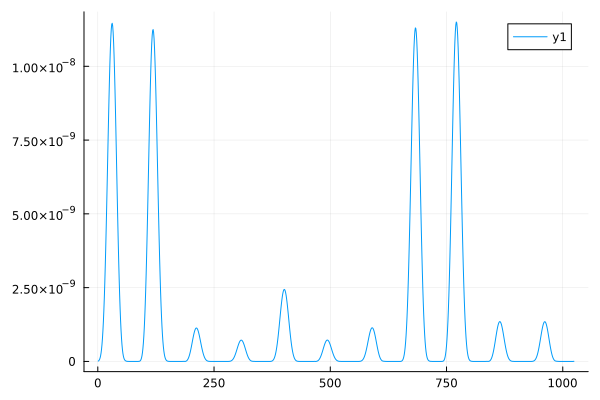

In [97]:
plot(abs.(final_pulse["amp"])[:,1])

In [32]:
fft_test = plan_fft(final_pulse[1], 1);
Nd = size(final_pulse[1])[1]
final_pulse_fft = [(1/Nd) .* (fft_test * final_pulse[idx]) for idx in 1:length(final_pulse)];
final_pulse_Eft = [(2*pi*Es/T_mod) .* 1e3 .* abs.(final_pulse_fft[idx]) .^ 2 for idx in 1:length(final_pulse)];
final_pulse_fft_b0 = [(1/Nd) .* (fft_test * final_pulse_b0[idx]) for idx in 1:length(final_pulse_b0)];
final_pulse_Eft_b0 = [(2*pi*Es/T_mod) .* 1e3 .* abs.(final_pulse_fft_b0[idx]) .^ 2 for idx in 1:length(final_pulse_b0)];

LoadError: KeyError: key 1 not found

In [ ]:
arr_freq = fftfreq(length(final_pulse[1][:,1]));
arr_freq_bin = arr_freq ./ (arr_freq[2] - arr_freq[1]);
# arr_real_freq = (.-arr_freq .* (length(arr_time)/ T_mod) .+ c0/(1.55e-6)) * 1e-12;
arr_real_freq =  .-arr_freq .* (length(arr_time)/ T_mod) .+ c0/(1.55e-6) * 1e-12;

sorted_freq_bin = sort(arr_freq_bin);
freq_order = sortperm(arr_freq_bin);
sorted_real_freq = arr_real_freq[freq_order];
sorted_real_lbd = (c0 ./ (sorted_real_freq .* 1e12)) .* 1e6;

In [ ]:
final_pulse_plot = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel = "Power (W)", title = var_title)
off = 0.0
for idp in 1:length(final_pulse)
    plot!(final_pulse_plot, sorted_time, (off * idp) .+ abs.(final_pulse[idp][time_order,1]).^2 * Es * 1e12,
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)", alpha = 0.5)
end
savefig(final_pulse_plot, figdir * "pulse_var_" * figlabel_var * ".png")
final_pulse_plot

In [ ]:
final_pulse_plot_b0 = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel = "Power (W)", title = var_title)
off = 0.0
for idp in 1:length(final_pulse)
    plot!(final_pulse_plot_b0, sorted_time, (off * idp) .+ abs.(final_pulse_b0[idp][time_order,1]).^2 * Es * 1e12,
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)", alpha = 0.5)
end
savefig(final_pulse_plot_b0, figdir * "pulse_var_b0_" * figlabel_var * ".png")
final_pulse_plot_b0

In [ ]:
final_pulse_fft_plot = plot(frame=:box, xlabel = "Wavelength (μm)", ylabel = "Power (dBm)", title = var_title, 
    xlim = (1.52,1.58), ylim = (-20.5,0.5), legend=:outerright, size=(700,400))
off = 0.0

for idp in 1:length(final_pulse_Eft)
    bar!(final_pulse_fft_plot, sorted_real_lbd, log10.(final_pulse_Eft[idp][freq_order,1]),color=color_10[idp],
        label = nothing, alpha = 0.05, fillrange = -30, barwidth = 1e-5)
end

for idp in 1:length(final_pulse_Eft)
    plot!(final_pulse_fft_plot, sorted_real_lbd, log10.(final_pulse_Eft[idp][freq_order,1]),
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)", color=color_10[idp])
end
savefig(final_pulse_fft_plot, figdir * "pulse_fft_var_" * figlabel_var * ".png")
final_pulse_fft_plot

In [ ]:
## Plotting the resulting signals

### Resonant EO Comb

Plot: How the resonant-EO evolves in time

# Pulses at all time
t_sample = 100:100:2000
idx = 5
outdir = "./output/test_master/"
outlabel = "resonant_eo"
figdir = "./figures/test_master/"
figlabel = "resonant_eo_$(idx)"

raw_data = [load("$(outdir)$(outlabel)_t$i.jld")["amp"][:,idx,:] for i in t_sample]

final_amp = raw_data[end]
final_spectrum = fft(final_amp[:,1]);
offset_amp = 75
amp_abs = [abs.(raw_data[i]) .+ offset_amp * (length(raw_data)-i) for i in 1:length(raw_data)];

arr_time = resonant_eo.ecpo_pulse.arr_time;
sorted_time = sort(arr_time);
time_order = sortperm(arr_time);
pm_phase = [resonant_eo.phase_mod_func(t, resonant_eo.T_mod, 1, resonant_eo.pars_pm[2]) for t in sorted_time];

arr_freq = fftfreq(length(final_amp[:,1]));
arr_freq_bin = arr_freq ./ (arr_freq[2] - arr_freq[1]);
sorted_freq_bin = sort(arr_freq_bin);
freq_order = sortperm(arr_freq_bin);

αst = 0.5

sorted_amp_abs = [amp_abs[i][time_order] for i in 1:length(amp_abs)]
pulse_evolve = plot(frame=:box, xlabel = "Cavity Time T (ns)", ylabel="Amplitude |Aₜ(T)|", 
    size=(700,400), legend=:outerright)
c_palette = palette(cgrad([:orange, :darkblue], [0.1, 0.3, 0.8]),length(raw_data))
for i in 1:length(raw_data)
    plot!(pulse_evolve, sorted_time, sorted_amp_abs[i], color=c_palette[i],
        alpha = αst + (1-αst) * i/length(raw_data), label = "t = $(t_sample[i])")
end
savefig(pulse_evolve, figdir * "pulse_evolve_" * outlabel * ".png")
pulse_evolve

eq_amp = plot(frame=:box, xlabel = "Cavity Time T (ns)", ylabel="Amplitude A(t)", size=(700,400),
    legend=:outerright)
plot!(eq_amp, sorted_time, abs.(final_amp[:,1])[time_order], color=:black, label = "Simulation: Abs[A(t)]")
plot!(eq_amp, sorted_time, real.(final_amp[:,1])[time_order], color=:purple, label = "Simulation: Re[A(t)]")
plot!(eq_amp, sorted_time, imag.(final_amp[:,1])[time_order], color=:red, label = "Simulation: Im[A(t)]")

plot!(eq_amp, sorted_time, abs.(amp_theory), color=:black, linestyle=:dash, label = "Theory: Abs[A(t)]")
plot!(eq_amp, sorted_time, real.(amp_theory), color=:purple, linestyle=:dash, label = "Theory: Re[A(t)]")
plot!(eq_amp, sorted_time, imag.(amp_theory), color=:red, linestyle=:dash, label = "Theory: Im[A(t)]")

plot!(eq_amp, sorted_time, 3e2 .* pm_phase, color =:gray, linestyle=:dash, label = "Phase Modulation ϕ(t)")
savefig(eq_amp, figdir * "equilibrium_amp_" * outlabel * ".png")
eq_amp

# Spectrum of the resonant EO comb
fid_max = 200
eq_spec = plot(frame=:box, xlabel = "Frequency index n", ylabel="|A(ωₙ)|", xlim = (-fid_max, fid_max), size=(500,300))
scatter!(eq_spec, arr_freq_bin, abs.(final_spectrum[:,1]), label = nothing, color=:blue)
sticks!(eq_spec, arr_freq_bin, abs.(final_spectrum[:,1]), label = nothing, color=:blue, alpha = 0.3)

plot!(eq_spec, sorted_freq_bin, length(arr_freq_bin) .* abs.(spec_theory)[freq_order], 
    color=:red, linestyle=:dash, label = "Theory")
savefig(eq_spec, figdir * "equilibrium_spectrum_" * outlabel * ".png")
eq_spec

### ECPO

#### Parametrizations

function read_ecpo_pars(idx, folder, filename, pars_label)
    raw_json = JSON.parsefile("$(folder)$(filename)_$(idx).json");
    return [raw_json[pars] for pars in pars_label]
end
pars_label = ("pump_max", "loss_signal", "pm_depth", "am_depth");
pars_matrix = [read_ecpo_pars(idx, "./input/ecpo_gpu_lp1064/", "ecpo_lp1064", pars_label) for idx in 1:324]
pars_matrix = hcat(pars_matrix...)

(f_mod, N_div) = read_ecpo_pars(1, "./input/ecpo_gpu_lp1064/", "ecpo_lp1064", ["f_mod", "N_div"])
T_mod = 1/f_mod * 1e-12
# sorted_time = collect(-0.5 / f_mod: 1/(N_div * f_mod): 0.5 / f_mod - 1e-6)

color_10 = palette(:tab10)

# Some ingredients
h = 6.626e-34
c0 = 3e8
λp = 1.064e-6; λs = 1.55e-6;
Ep = h * c0 / λp;
Es = h * c0 / λs;

# How to extract relevant index
idxs = intersect!(
    findall(loss -> loss == 0.5, pars_matrix[2,:]), 
    findall(pm_depth -> pm_depth == 3.0, pars_matrix[3,:]), 
    findall(am_depth -> am_depth == 1.0, pars_matrix[4,:]))

#### Steady state under different parameters

# Change the condition for the plots
var_id = 4; n_vars = 4;
(a_in, α, ϕpm, ϕam) = [6000., 0.5, 3.0, 1.5]

# Parameters
not_var_id = deleteat!(collect(1:4), var_id)
var_labels = ("Pᵢₙ", "α", "ϕₚₘ", "ϕₐₘ")
var_units = (" W", "", "", "")
pars = (a_in, α, ϕpm, ϕam) .^ (2,1,1,1) .* (Ep * 1e12, 1,1,1)

# Find the indices
cond1 = findall(pump -> pump == a_in, pars_matrix[1,:])
cond2 = findall(loss -> loss == α, pars_matrix[2,:])
cond3 = findall(pm_depth -> pm_depth == ϕpm, pars_matrix[3,:])
cond4 = findall(am_depth -> am_depth == ϕam, pars_matrix[4,:])
cond_list = deleteat!([cond1, cond2, cond3, cond4], var_id)

idxs = intersect!(cond_list...)
δidx = idxs[2]-idxs[1];

var_label = var_labels[var_id]
var_unit = var_units[var_id]
var_values = (abs.(pars_matrix[1,idxs]).^2 * Ep * 1e12,
    pars_matrix[2,idxs], pars_matrix[3,idxs], pars_matrix[4,idxs])[var_id];
var_title = join(["$(var_labels[id_var]) = $(round(pars[id_var], digits=2))$(var_units[id_var]); " for id_var in not_var_id]);

obj = ecpo_vec[idx]
outdir = "./output/ecpo_gpu_lp1064/"

outlabel = "ecpo_lp$(lp)"
figdir = "./figures/ecpo_gpu_lp1064/"
figlabel_var = "ecpo_lp$(lp)_idxs$(idxs[begin])_$(δidx)_$(idxs[end])"

tfin = 1000
final_pulse = [load("$(outdir)$(outlabel)_t$(tfin).jld")["amp"][:,idx,:] for idx in idxs];
final_pulse_b0 = [load("$(outdir_b0)$(outlabel)_t$(tfin).jld")["amp"][:,idx,:] for idx in idxs];

pump_power = abs.(pars_matrix[1,idxs]).^2 * Es * 1e12;

fft_test = plan_fft(final_pulse[1], 1);
Nd = size(final_pulse[1])[1]
final_pulse_fft = [(1/Nd) .* (fft_test * final_pulse[idx]) for idx in 1:length(final_pulse)];
final_pulse_Eft = [(2*pi*Es/T_mod) .* 1e3 .* abs.(final_pulse_fft[idx]) .^ 2 for idx in 1:length(final_pulse)];
final_pulse_fft_b0 = [(1/Nd) .* (fft_test * final_pulse_b0[idx]) for idx in 1:length(final_pulse_b0)];
final_pulse_Eft_b0 = [(2*pi*Es/T_mod) .* 1e3 .* abs.(final_pulse_fft_b0[idx]) .^ 2 for idx in 1:length(final_pulse_b0)];

arr_freq = fftfreq(length(final_pulse[1][:,1]));
arr_freq_bin = arr_freq ./ (arr_freq[2] - arr_freq[1]);
# arr_real_freq = (.-arr_freq .* (length(arr_time)/ T_mod) .+ c0/(1.55e-6)) * 1e-12;
arr_real_freq =  .-arr_freq .* (length(arr_time)/ T_mod) .+ c0/(1.55e-6) * 1e-12;

sorted_freq_bin = sort(arr_freq_bin);
freq_order = sortperm(arr_freq_bin);
sorted_real_freq = arr_real_freq[freq_order];
sorted_real_lbd = (c0 ./ (sorted_real_freq .* 1e12)) .* 1e6;

final_pulse_plot = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel = "Power (W)", title = var_title)
off = 0.0
for idp in 1:length(final_pulse)
    plot!(final_pulse_plot, sorted_time, (off * idp) .+ abs.(final_pulse[idp][time_order,1]).^2 * Es * 1e12,
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)", alpha = 0.5)
end
savefig(final_pulse_plot, figdir * "pulse_var_" * figlabel_var * ".png")
final_pulse_plot

final_pulse_plot_b0 = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel = "Power (W)", title = var_title)
off = 0.0
for idp in 1:length(final_pulse)
    plot!(final_pulse_plot_b0, sorted_time, (off * idp) .+ abs.(final_pulse_b0[idp][time_order,1]).^2 * Es * 1e12,
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)", alpha = 0.5)
end
savefig(final_pulse_plot_b0, figdir * "pulse_var_b0_" * figlabel_var * ".png")
final_pulse_plot_b0

final_pulse_fft_plot = plot(frame=:box, xlabel = "Wavelength (μm)", ylabel = "Power (dBm)", title = var_title, 
    xlim = (1.52,1.58), ylim = (-20.5,0.5), legend=:outerright, size=(700,400))
off = 0.0

for idp in 1:length(final_pulse_Eft)
    bar!(final_pulse_fft_plot, sorted_real_lbd, log10.(final_pulse_Eft[idp][freq_order,1]),color=color_10[idp],
        label = nothing, alpha = 0.05, fillrange = -30, barwidth = 1e-5)
end

for idp in 1:length(final_pulse_Eft)
    plot!(final_pulse_fft_plot, sorted_real_lbd, log10.(final_pulse_Eft[idp][freq_order,1]),
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)", color=color_10[idp])
end
savefig(final_pulse_fft_plot, figdir * "pulse_fft_var_" * figlabel_var * ".png")
final_pulse_fft_plot

final_pulse_fft_plot_b0 = plot(frame=:box, xlabel = "Wavelength (μm)", ylabel = "Power (dBm)", title = var_title, 
    xlim = (1.52,1.58), ylim = (-20.5,0.5),legend=:outerright, size=(700,400))
off = 0.0
for idp in 1:length(final_pulse_Eft)
    bar!(final_pulse_fft_plot_b0, sorted_real_lbd, log10.(final_pulse_Eft_b0[idp][freq_order,1]),color=color_10[idp],
        label = nothing, alpha = 0.1, fillrange = -30)
end

for idp in 1:length(final_pulse_Eft)
    plot!(final_pulse_fft_plot_b0, sorted_real_lbd, log10.(final_pulse_Eft_b0[idp][freq_order,1]),color=color_10[idp],
        label = "$(var_label) = $(round(var_values[idp], digits=2)) $(var_unit)")
end
savefig(final_pulse_fft_plot_b0, figdir * "pulse_fft_var_b0_" * figlabel_var * ".png")
final_pulse_fft_plot_b0

#### Pulse evolution (time and frequency domain)

# Pulses at all time
t_sample = 10:10:500
idx = 250
lp = 1064

"""
# FOR CPU
object = res_ecpo
outdir = "./output/ecpo_cpu_lp1064/"
outlabel = "ecpo_lp$(lp)_$(idx)"
figdir = "./figures/ecpo_cpu_lp1064/"
figlabel = "ecpo_lp$(lp)_$(idx)"
"""

# FOR GPU
obj = ecpo_vec[idx]
outdir = "./output/ecpo_gpu_lp1064/"
outdir_b0 = "./output/ecpo_gpu_lp1064_b0/"
outlabel = "ecpo_lp$(lp)"
figdir = "./figures/ecpo_gpu_lp1064/"
figlabel = "ecpo_lp$(lp)_$(idx)";

# Define the time and frequency
arr_time = obj.ecpo_pulse.arr_time;
sorted_time = sort(arr_time);
time_order = sortperm(arr_time);
pm_phase = [res_ecpo.phase_mod_func(t, obj.T_mod, 1, obj.pars_pm[2]) for t in sorted_time];

T_mod = 2 * (maximum(arr_time) + (arr_time[2] - arr_time[1])) * 1e-12

arr_freq = fftfreq(length(final_amp[:,1]));
arr_freq_bin = arr_freq ./ (arr_freq[2] - arr_freq[1]);
arr_real_freq =  (.-arr_freq .* (length(arr_time)/ T_mod) .+ c0/(1.55e-6)) * 1e-12;

sorted_freq_bin = sort(arr_freq_bin);
freq_order = sortperm(arr_freq_bin);
sorted_real_freq = arr_real_freq[freq_order];
sorted_real_lbd = (c0 ./ (sorted_real_freq .* 1e12)) .* 1e6;

# raw_data = [load("$(outdir)$(outlabel)_t$i.jld")["amp"] for i in t_sample]
raw_data = [load("$(outdir)$(outlabel)_t$i.jld")["amp"][:,idx,:] for i in t_sample]

# Labels
pars_labels = ("Pᵢₙ", "α", "ϕₚₘ", "ϕₐₘ")
pars_units = (" W", "", "", "")
pars_now = pars_matrix[:,idx] .^ (2,1,1,1) .* (Ep * 1e12, 1,1,1)
evolve_title = join(["$(pars_labels[id_var]) = $(round(pars_now[id_var], digits=2))$(var_units[id_var]); " 
        for id_var in 1:length(pars_labels)]);

final_amp = raw_data[end]
final_spectrum = fft(final_amp[:,1]);
offset_amp = 0.0;

# Calculation in time domain
Nd = size(raw_data[begin])[1]
amp_abs = [abs.(raw_data[i]) .+ offset_amp * (length(raw_data)-i) for i in 1:length(raw_data)];
amp_real = [real.(raw_data[i]) for i in 1:length(raw_data)];
amp_imag = [imag.(raw_data[i]) for i in 1:length(raw_data)];

# Modulation
(key_f, freq_mod, pm_d, pm_p) = read_ecpo_pars(idx, "./input/ecpo_gpu_lp1064/", 
    "ecpo_lp1064", ["phase_mod_f", "f_mod", "pm_depth", "pm_phase"]);
arr_pm = exp.(1im.*[modulation_func[key_f](t, 1/freq_mod, pm_d, pm_p) for t in arr_time])
sorted_pm = arr_pm[time_order]

# Sorted amplitude
sorted_amp_abs = [amp_abs[i][time_order] for i in 1:length(amp_abs)];
sorted_amp_real = [amp_real[i][time_order] for i in 1:length(amp_real)];
sorted_amp_imag = [amp_imag[i][time_order] for i in 1:length(amp_imag)];
sorted_phase_nl = [angle.(amp_real[i][time_order] + 1im .* amp_imag[i][time_order]) 
    for i in 1:length(amp_real)];
sorted_phase_tot = [angle.((amp_real[i][time_order] + 1im .* amp_imag[i][time_order]) .* 
    arr_pm[time_order]) for i in 1:length(amp_real)];

# Calculation in frequency domain
sorted_fft = [(1/Nd) .* fft(raw_data[i][:,1])[freq_order] for i in 1:length(raw_data)];
sorted_fft_real = [real.(sorted_fft[i]) for i in 1:length(sorted_fft)];
sorted_fft_imag = [imag.(sorted_fft[i]) for i in 1:length(sorted_fft)];
sorted_fft_abs = [abs.(sorted_fft[i]) for i in 1:length(sorted_fft)];
sorted_Eft = [(2*pi*Es/T_mod) .* 1e3 .* sorted_fft_abs[i].^2 for i in 1:length(sorted_fft)];
sorted_fft_phase = [angle.(sorted_fft[i]) for i in 1:length(sorted_fft)];

αst = 0.5

pulse_evolve = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel="Power (W)", 
    size=(600,400), legend=:outerright, title=evolve_title)
c_palette = palette(cgrad([:orange, :darkblue], [0.1, 0.3, 0.8]),length(raw_data))
for i in 1:length(raw_data)
    plot!(pulse_evolve, sorted_time, sorted_amp_abs[i] .^2 * Es * 1e12, color=c_palette[i],
        alpha = αst + (1-αst) * i/length(raw_data), label = nothing)
end
savefig(pulse_evolve, figdir * "pulse_evolve_" * figlabel * ".png")
pulse_evolve

αst = 0.5
f_window = (190,197)

pulse_fft_evolve = plot(frame=:box, xlabel = "Frequency (THz)", ylabel="Power (dBm)", 
    size=(600,400), legend=:outerright, title=evolve_title, xlim = f_window)
c_palette = palette(cgrad([:orange, :darkblue], [0.1, 0.3, 0.8]),length(raw_data))
for i in 1:length(raw_data)
    plot!(pulse_fft_evolve, sorted_real_freq, log10.(sorted_Eft[i]), color=c_palette[i],
        alpha = αst + (1-αst) * i/length(raw_data), label = nothing)
end
# savefig(pulse_evolve, figdir * "pulse_fft_evolve_" * figlabel * ".png")
pulse_fft_evolve

αst = 0.5
l_window = (1.525,1.575)

pulse_lbd_evolve = plot(frame=:box, xlabel = "Wavelength (μm)", ylabel="Power (dBm)", 
    size=(600,400), legend=:outerright, title=evolve_title, xlim = l_window)
c_palette = palette(cgrad([:orange, :darkblue], [0.1, 0.3, 0.8]),length(raw_data))
for i in 1:length(raw_data)
    plot!(pulse_lbd_evolve, sorted_real_lbd, log10.(sorted_Eft[i]), color=c_palette[i],
        alpha = αst + (1-αst) * i/length(raw_data), label = nothing)
end
# savefig(pulse_evolve, figdir * "pulse_fft_evolve_" * figlabel * ".png")
pulse_lbd_evolve

# Plotting the pulse development over time
time_matrix = repeat(collect(t_sample), 1, length(arr_time))

pulse_evolve_3d = plot3d(size=(600,600,600), frame=:box,
    title = evolve_title,
    xlabel = "Cycle n", 
    ylabel = "Time T (ps)", 
    zlabel = "Power (W)")

for i in 1:size(sorted_amp_abs)[1]
    plot3d!(pulse_evolve_3d, time_matrix[i,:], sorted_time, sorted_amp_abs[i] .^2 .*(Es * 1e12), 
        color=c_palette[i], label=nothing, camera = (50,30))
end
savefig(pulse_evolve_3d, figdir * "pulse_evolve_3d_" * figlabel * ".png")
pulse_evolve_3d

# Plotting the pulse development over time
time_matrix = repeat(collect(t_sample), 1, length(arr_time))

pulse_evolve_lbd_3d = plot3d(size=(600,600,600), frame=:box,
    title = evolve_title,
    ylim = (1.5,1.6),
    xlabel = "Cycle n", 
    ylabel = "Wavelength λ (μm)", 
    zlabel = "Power (dBm)")

for i in 1:size(sorted_amp_abs)[1]
    plot3d!(pulse_evolve_lbd_3d, time_matrix[i,:], sorted_real_lbd, log10.(sorted_Eft[i]), 
        color=c_palette[i], label=nothing, camera = (55,30))
end
savefig(pulse_evolve_lbd_3d, figdir * "pulse_evolve_lbd_3d_" * figlabel * ".png")
pulse_evolve_lbd_3d

plot_amp_full = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel="A(T) (1/√ps)", 
    size=(600,400), legend=:outerright, title=evolve_title)

plot!(plot_amp_full, sorted_time, sorted_amp_real[end][:,1], color=:darkblue, label="Re[A(t)]")
plot!(plot_amp_full, sorted_time, sorted_amp_imag[end][:,1], color=:darkblue, linestyle=:dash, label="Im[A(t)]")

savefig(plot_phase, figdir * "plot_amp_full_" * figlabel * ".png")
plot_amp_full

plot_phase = plot(frame=:box, xlabel = "Cavity Time T (ps)", ylabel="ϕₙₗ (rad)", 
    size=(600,400), legend=:outerright, title=evolve_title)

plot!(plot_phase, sorted_time, sorted_phase_nl[end][:,1], color=:red, label="ϕₙₗ", linestyle=:dash)
plot!(plot_phase, sorted_time, angle.(sorted_pm), color=:blue, label="ϕₚₘ", linestyle=:dash)
plot!(plot_phase, sorted_time, sorted_phase_tot[end][:,1], color=:black,label="ϕₜₒₜ")

savefig(plot_phase, figdir * "pulse_phase_" * figlabel * ".png")
plot_phase

plot_phase_evolve = plot3d(frame=:box, 
    xlabel = "Steps\nn", 
    ylabel = "Time T (ps)", 
    zlabel="ϕₜₒₜ (rad)", 
    size=(600,600), title=evolve_title, 
    xguidefontrotation = 70,
    camera = (75,30))

for i in 1:length(sorted_phase)
    plot3d!(plot_phase_evolve, time_matrix[i,:], sorted_time, sorted_phase_tot[i][:,1], color=c_palette[i],
        alpha = αst + (1-αst) * i/length(sorted_phase_tot), label=nothing)
end

savefig(plot_phase_evolve, figdir * "phase_evolve_" * figlabel * ".png")
plot_phase_evolve

#### Fourier transform

#### The spectrogram

using Interpolations

# Pulses at all time
t_sample = 10:10:500
idx = 142
lp = 1064

# FOR GPU
obj = ecpo_vec[idx]
outdir = "./output/ecpo_gpu_lp1064/"
outdir_b0 = "./output/ecpo_gpu_lp1064_b0/"
outlabel = "ecpo_lp$(lp)"
figdir = "./figures/ecpo_gpu_lp1064/"
figlabel = "ecpo_lp$(lp)_$(idx)";

raw_data = [load("$(outdir)$(outlabel)_t$i.jld")["amp"][:,idx,:] for i in t_sample];

m_sample = 2^8; # The original one
n_sample = 2^8; # The interpolated one
T_mod = (2 * (maximum(arr_time) + (arr_time[2] - arr_time[1]))) * 1e-12
T_spec = m_sample/length(arr_time) * T_mod

disc_signal = raw_data[end][time_order,1]
disc_signal = vcat(disc_signal[end-Int(m_sample/2)+1:end], disc_signal, disc_signal[1:Int(m_sample/2)])
spec_matrix = zeros(ComplexF32, n_sample, length(arr_time))
t_points = collect(1:m_sample/n_sample:m_sample+1-1/n_sample);
for j in 1:length(arr_time)
    itp = interpolate(disc_signal[j:m_sample+j], BSpline(Quadratic()));
    spec_matrix[:,j] = [itp(t) for t in t_points];
end

fft_spec = plan_fft!(spec_matrix, 1)
ifft_spec = plan_ifft!(spec_matrix, 1)
spec_freq_matrix = fft_spec * spec_matrix;

# Frequency
spec_freq = (.-fftfreq(size(spec_matrix)[1]) .* (n_sample / T_spec) .+ c0/(1.55e-6) ) * 1e-12;
freq_order = sortperm(spec_freq);
sorted_freq = sort(spec_freq);

# Lambda
spec_lbd = (c0 ./ (spec_freq .* 1e12)) .* 1e6;
lbd_order = sortperm(spec_lbd);
sorted_lbd = spec_lbd[lbd_order];
# raw_data[end][:,1];

mat_X = repeat(spec_freq,1,length(arr_time))
mat_Y = transpose(repeat(sorted_time, 1, m_sample))
heatmap(sorted_time, sorted_lbd, abs.(spec_freq_matrix[lbd_order,:]),
    xlabel = "Time T (ps)", ylabel = "Wavelength (μm)", ylim = (1.45, 1.65),
    levels=30, color=:turbo)

plot(spec_freq, abs.(spec_freq_matrix[freq_order,900]), xlim = (-5,5))